## Multiple simultaneous RL agent training
In this example, we consider training multiple RL agents using learning algorithms from RLlib. To run this example, the package ray[rllib] needs to be installed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [4]:
import sys, os
sys.path.append('/home/jovyan/work/biddingStrategy/src')

from environments import MultiAgentTrainingEnv
from info_settings import OfferInformationSetting, TimeInformationWrapper
from agents import GymRLAgent, TimeLinearAgent

from ray.rllib.env.multi_agent_env import MultiAgentEnv

from gym.spaces import Box, Discrete

Before we can use RLlib's algorithms, we need to wrap our own MultiAgentTrainingEnv to make it compatible with RLlib. This is very easy:

In [5]:
class MultiWrapper(MultiAgentTrainingEnv, MultiAgentEnv):
    def __init__(self, env_config):
        super().__init__(**env_config)

Then we can simply define RL agents & fixed agents and the info setting as usual.

## Cooperative play
We have the following setting:

<li>1 RL buyer and 1 RL seller</li>
<li>1 linear buyer and 1 linear seller</li>
The linear buyer will bid low first and raise its bid quickly. The linear seller will start high and drop its price, but at a slower pace. The best situation for both agent would be that the RL seller grabs the linear buyer first so that the RL buyer can wait till the linear seller drops his price minimally. Both RL agents do not have access to timestamp, unlike the linear agents! Will they be able to coordinate?m

In [6]:
rl_agents = [
    GymRLAgent('seller', 90, 'S1', max_factor=0.25, discretization=20),
    GymRLAgent('buyer', 110, 'B1', max_factor=0.25, discretization=20),
]
fixed_agents = [
    TimeLinearAgent('buyer', 110, 'TB1', noise=0., max_steps=6),
    TimeLinearAgent('seller', 90, 'TS3', noise=0., max_steps=20),
]
setting = TimeInformationWrapper(OfferInformationSetting(1))
env = MultiAgentTrainingEnv(rl_agents, fixed_agents, setting) # Just for convenience

Since RLlib works with policies and mapping of agent_id to policy_id, we should define the types of policies we use. Here, we use the default policy (which is usually based on a MLP neural network).

In [7]:
my_policy = (None, env.observation_space, Discrete(20), {}) 
# None means this policy needs to be learned.
# Note: The action space should match that of the GymRLAgent defined earlier

def select_policy(agent_id):
    """This function maps the agent id to the policy id"""
    return agent_id

# We name our policies the same as our RL agents
policies = {
    'S1': my_policy,
    'B1': my_policy,
}

For the RL algorithm, we'll using Deep-Q. To initialize the trainer, we pass the MultiWrapper class. The parameters will be passed through the env_config dictionary.

In [8]:
from ray.rllib.agents import dqn

trainer = dqn.DQNTrainer(env=MultiWrapper, config={
    "env_config": {"rl_agents": rl_agents, "fixed_agents": fixed_agents, "setting": setting},
    "timesteps_per_iteration": 30,
    "multiagent": {
        "policies": policies,
        "policy_mapping_fn": select_policy
    },
    "log_level": "ERROR",
})

Now we're ready to train! Simply calling trainer.train() will train the agents for one iteration. One such iteration will contain at least 30 market timesteps (but usually more), as specified above.

This call will return some data regarding the training, we'll keep track of the mean episode reward during each iteration and the mean episode length of each iteration.

In [9]:
rewards = []
episodes = []
episode_len = []

Let's train for 250 iterations. This should take about 5 minutes.

In [10]:
%%time
for i in range(250):
    result = trainer.train()
    # append data, each of them is a single dictionary
    rewards.append(result['policy_reward_mean'])
    episodes.append(result['episodes_total'])
    episode_len.append(result['episode_len_mean'])

CPU times: user 4min 21s, sys: 1min 1s, total: 5min 22s
Wall time: 4min 28s


Time to plot the results:

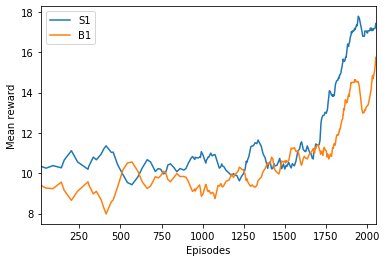

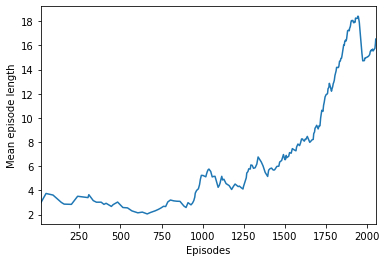

In [11]:
rew_df = pd.DataFrame(rewards, index=episodes)
rew_df.index.name = 'Episodes'
rew_df.plot()

plt.ylabel("Mean reward")

plt.figure()
len_df = pd.Series(episode_len, index=episodes)
len_df.index.name = 'Episodes'
len_df.plot()
_ = plt.ylabel("Mean episode length")